In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

from tsa import config

np.random.seed(42)

In [17]:
df = pd.read_csv(
    config.INTERIM_DATA_DIR / "combined.csv", parse_dates=True, index_col=0
)
df.head()

,ZWEX,IMPI,GDP,GDP_growth,CHECPIALLMINMEI,IRLTLT01CHM156N,net_migration,population,vacancy_rate
1993-01-01,103.77,115.447844,112130.448638,-0.332376,86.47165,5.539,2238.0,363504.0,0.30
1993-04-01,104.49,115.783942,113159.227131,0.917484,87.75593,4.845,816.0,364188.0,0.30
1993-07-01,104.10,113.425045,113590.721726,0.381316,87.73057,4.546,-1504.0,362572.0,0.30
1993-10-01,103.78,113.624620,114212.328316,0.547234,88.17464,4.208,-1491.0,360898.0,0.30
1994-01-01,104.98,115.409362,114854.744384,0.562475,88.26907,4.206,1886.0,362604.0,0.42


In [18]:
df_returns = pd.DataFrame(index=df.index)
df_returns["zwex_return"] = df["ZWEX"].pct_change() * 100
df_returns["impi_return"] = df["IMPI"].pct_change() * 100
df_returns["inflation_rate"] = df["CHECPIALLMINMEI"].pct_change() * 100
df_returns["rate_change"] = df["IRLTLT01CHM156N"].diff()
df_returns["population_change"] = df["population"].pct_change() * 100
df_returns["vacancy_rate"] = df["vacancy_rate"]
df_returns["gdp_growth"] = df["GDP_growth"]
df_returns.dropna(inplace=True)
len(df_returns)

127

## Stationarity Checks

In [19]:
def check_stationarity(series, name):
    adf_result = adfuller(series)
    adf_statistic, adf_pvalue = adf_result[0], adf_result[1]

    adf_stationary = adf_pvalue < 0.05

    return {
        "Series": name,
        "ADF Statistic": adf_statistic,
        "ADF p-value": adf_pvalue,
        "ADF Stationary": adf_stationary,
    }

In [20]:
stationarity_results = []
for col in df_returns.columns:
    result = check_stationarity(df_returns[col], col)
    stationarity_results.append(result)

stationarity_df = pd.DataFrame(stationarity_results)
print(stationarity_df)

              Series  ADF Statistic   ADF p-value  ADF Stationary
0        zwex_return      -2.923957  4.263225e-02            True
1        impi_return      -1.967091  3.011863e-01           False
2     inflation_rate      -4.075915  1.061219e-03            True
3        rate_change     -10.328766  2.879111e-18            True
4  population_change      -1.916019  3.245631e-01           False
5       vacancy_rate      -2.283673  1.772879e-01           False
6         gdp_growth     -11.678864  1.761053e-21            True


## Structural change check

I considered using a Chow-test, but it was easier to use the cusum implementation from statsmodels.

In [21]:
def cusum_test(series, name):
    endog = series.dropna()
    exog = sm.add_constant(range(len(endog)))

    mod = sm.RecursiveLS(endog, exog)
    res = mod.fit()

    with plt.style.context("default"):
        fig = res.plot_cusum()
        plt.title(f"CUSUM Test {name}")
        plt.show()

/Users/liamtessendorf/Programming/Uni/2_Master/5_HS25_Programming/tsa/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


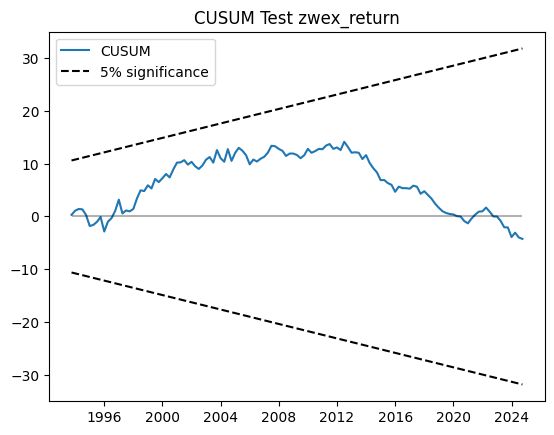

/Users/liamtessendorf/Programming/Uni/2_Master/5_HS25_Programming/tsa/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


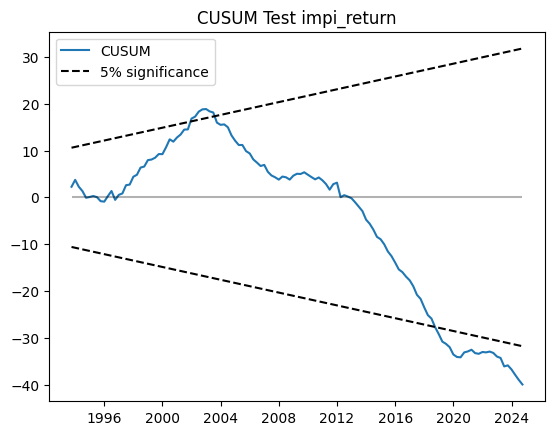

/Users/liamtessendorf/Programming/Uni/2_Master/5_HS25_Programming/tsa/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


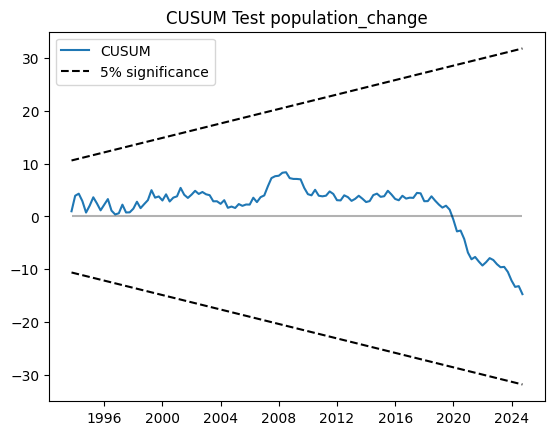

/Users/liamtessendorf/Programming/Uni/2_Master/5_HS25_Programming/tsa/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


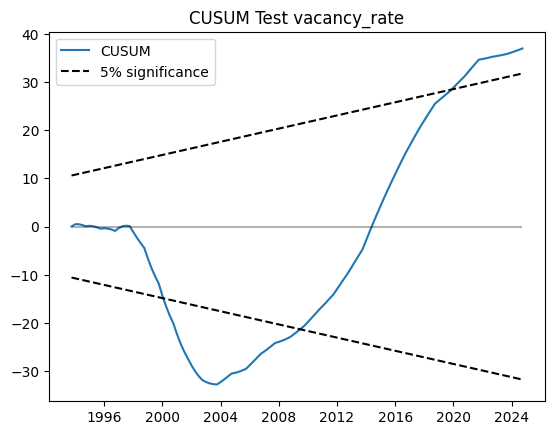

In [22]:
for col_name in ["zwex_return", "impi_return", "population_change", "vacancy_rate"]:
    cusum_test(df_returns[col_name], col_name)

In [23]:
def test_stationarity_with_break(series, break_date):
    df = pd.DataFrame({"y": series})
    df["y_lag"] = df["y"].shift(1)
    df = df.dropna()

    df["D"] = (df.index >= pd.to_datetime(break_date)).astype(int)
    df["D_y_lag"] = df["D"] * df["y_lag"]

    X = sm.add_constant(df[["y_lag", "D", "D_y_lag"]])
    model = sm.OLS(df["y"], X).fit()

    print(model.summary())

    residuals = model.resid
    adf_result = adfuller(residuals)
    print(f"\nResidual ADF Statistic: {adf_result[0]:.4f}")
    print(f"Residual p-value:       {adf_result[1]:.4f}")

In [24]:
test_stationarity_with_break(df_returns["vacancy_rate"], "2000-01-01")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     815.8
Date:                Wed, 28 Jan 2026   Prob (F-statistic):           1.61e-80
Time:                        17:30:09   Log-Likelihood:                 234.90
No. Observations:                 126   AIC:                            -461.8
Df Residuals:                     122   BIC:                            -450.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0809      0.031      2.640      0.0

$p<0.05$, so we can model vacany rates using a structural break dummy.

So we will use first differences for IMPI return and population change, and model vacacy rates with one structural change dummy.

In [25]:
df_returns_stationary = pd.DataFrame(index=df.index)
df_returns_stationary["zwex_return"] = df["ZWEX"].pct_change() * 100
df_returns_stationary["impi_return"] = df["IMPI"].pct_change() * 100
df_returns_stationary["inflation_rate"] = df["CHECPIALLMINMEI"].pct_change() * 100
df_returns_stationary["rate_change"] = df["IRLTLT01CHM156N"].diff()
df_returns_stationary["population_change"] = df["population"].pct_change() * 100
df_returns_stationary["vacancy_rate"] = df["vacancy_rate"]
df_returns_stationary["gdp_growth"] = df["GDP_growth"]

# differencing for stationarity
df_returns_stationary["population_change_d"] = df_returns_stationary[
    "population_change"
].diff()
df_returns_stationary.dropna(inplace=True)
len(df_returns_stationary)

126

Check stationarity again:

In [26]:
stationarity_results = []
for col in df_returns_stationary.columns:
    result = check_stationarity(df_returns_stationary[col], col)
    stationarity_results.append(result)

stationarity_df = pd.DataFrame(stationarity_results)
print(stationarity_df)

                Series  ADF Statistic   ADF p-value  ADF Stationary
0          zwex_return      -2.472164  1.223949e-01           False
1          impi_return      -2.000015  2.865667e-01           False
2       inflation_rate      -3.983642  1.498632e-03            True
3          rate_change     -10.241511  4.736003e-18            True
4    population_change      -1.910105  3.273225e-01           False
5         vacancy_rate      -2.289939  1.752333e-01           False
6           gdp_growth     -11.620515  2.390776e-21            True
7  population_change_d      -5.136276  1.184591e-05            True


we lost one observation because we had to diff to make population_change stationary, which caused zwex_return to no longer be stationary. For this reason, we will check if zwex_return and impi_return are cointegrated.

In [27]:
def check_cointegration(series_y, series_x):
    df_coint = pd.concat([series_y, series_x], axis=1)
    y = df_coint.iloc[:, 0]
    x = df_coint.iloc[:, 1]

    score, p_value, crit_val = coint(y, x)

    print(f"t-statistic: {score:.4f}")
    print(f"p-value:     {p_value:.4f}")


check_cointegration(df_returns["zwex_return"], df_returns["impi_return"])

t-statistic: -3.5629
p-value:     0.0272


since impi_return and zwex_return are cointegrated ($p<0.5$), we don't have to worry about spurious regressions and don't have to use first differences.

In [28]:
df_returns_stationary.drop(columns=["population_change"], inplace=True)

In [29]:
stationarity_results = []
for col in df_returns_stationary.columns:
    result = check_stationarity(df_returns_stationary[col], col)
    stationarity_results.append(result)

stationarity_df = pd.DataFrame(stationarity_results)
print(stationarity_df)

                Series  ADF Statistic   ADF p-value  ADF Stationary
0          zwex_return      -2.472164  1.223949e-01           False
1          impi_return      -2.000015  2.865667e-01           False
2       inflation_rate      -3.983642  1.498632e-03            True
3          rate_change     -10.241511  4.736003e-18            True
4         vacancy_rate      -2.289939  1.752333e-01           False
5           gdp_growth     -11.620515  2.390776e-21            True
6  population_change_d      -5.136276  1.184591e-05            True


So in summary: zwex_return and impi_return are cointegrated, and for vacancy rate we will use a dummy variable to model the strucutral change in the year 2000.

In [30]:
df_returns_stationary.to_csv(config.PROCESSED_DATA_DIR / "combined_stationary.csv")